# Siamese CNN
In this file we are building a Siamese network for one shot classification of the malwares
The twin network is made of CNN
trainig is done on the pairs of classes from the malware dataset

This implementation of Siamese network is inspired from the keras examples
Reference: https://keras.io/examples/mnist_siamese/

In [2]:
# data manipulation libraries
import numpy as np
import random

# plotting with matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import keras, models, layers etc..
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2

# jobloib for pickeling, train test split
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

# number of classes # where 1 = malware and  0 = benign
num_classes = 2
# shape of the images
shape_w = 12
shape_h = 12


Using TensorFlow backend.


In [3]:
# load the pre-processed data which is in the form of images
data = joblib.load(r"dataset\X-11110-12-12-1" )
labels = joblib.load(r"dataset\labels-11110" )
print(data.shape)
print(labels.shape)

(11110, 12, 12, 1)
(11110,)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(data , labels, test_size = 0.33 , random_state = 4)

In [5]:
input_shape = x_train.shape[1:]
print("Input shape of the images data= ")
print(input_shape)
print("All training data shape = ")
print(x_train.shape)

Input shape of the images data= 
(12, 12, 1)
All training data shape = 
(7443, 12, 12, 1)


In [5]:
x_train.shape[1:]

(12, 12, 1)

In [10]:
# Create function

# find euclidean distance between two vectors for distance layer of the Siamese Network
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# convert to the output shape
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


# create pairs for two data points 
def create_pairs(x, img_indices):
    pairs = []
    labels = []
    n = min([len(img_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = img_indices[d][i], img_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = img_indices[d][i], img_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# Classification accuracy with a 0.5 threshold on distances
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# Contrastive loss function
- a distance based loss function appropriate for Siamese n/w (instead prediction error based like logistic loss # or hinge loss for classification ). 
- tries to make sure that semantically similar instances stay close together - neighbors are pulled together and non-neighbors are pushed apart 
- It is calculated on pairs. Other example of similer loss funs - triplet loss.

- Good explanation https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e
- main ref: Contrastive loss from Hadsell-et-al.'06
http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf


In [11]:
# contrastive loss function
# y_pred = Dw; distance putput b/w two pairs
# y_true = 0 is if pairs are similer and 1 if not

def contrastive_loss(y_true, y_pred):
    # margin greater than 0; dissimiler pairs beyond this margin will not contribute to the loss
    # we only want to optimise the network based on pairs that are actually dissimilar , 
    # but the network thinks are fairly similar.
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [18]:
def create_base_network(input_shape):
    # CNN with 5X5 filter
    img_size = (shape_w * shape_h )
    
    input = Input(shape=input_shape)
    x = Sequential()(input)
    
    x = Conv2D(img_size, (5, 5), input_shape= input_shape, activation='relu', padding = 'same')(x)
    # pooling layer
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 50% dropout rate
    x = Dropout(0.5)(x)

    # this converts our 3D feature maps to 1D feature vectors
    x = Flatten()(x)
    x = Dense(8, activation='relu')(x)
    
    # after this layer model will be followed by distance layer and then output layer
    
    return Model(input, x)


In [19]:
# create training and validation set for positve(same) and negative (different) pairs
img_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, img_indices)

img_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, img_indices)

# build base network 
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# As these are twin netowrks , so we the weights will be shared across the layers
# netowrk pair :-
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# calculate distance between processed data on a and b
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# buld model
model = Model([input_a, input_b], distance)


In [20]:
# complie the model and see the params
model.compile(loss=contrastive_loss, optimizer=RMSprop(), metrics=[accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 12, 12, 1)    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 12, 12, 1)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 8)            45224       input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           model_3[1][0]                    
          

In [21]:
# train
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=32,
          epochs=20,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))



Train on 14848 samples, validate on 7296 samples
Epoch 1/20
14848/14848 [==============================] - 8s 566us/step - loss: 0.1104 - accuracy: 0.8575 - val_loss: 0.0643 - val_accuracy: 0.9283
Epoch 2/20
14848/14848 [==============================] - 8s 545us/step - loss: 0.0677 - accuracy: 0.9267 - val_loss: 0.0550 - val_accuracy: 0.9368
Epoch 3/20
14848/14848 [==============================] - 11s 714us/step - loss: 0.0610 - accuracy: 0.9358 - val_loss: 0.0522 - val_accuracy: 0.9412
Epoch 4/20
14848/14848 [==============================] - 11s 766us/step - loss: 0.0567 - accuracy: 0.9432 - val_loss: 0.0493 - val_accuracy: 0.9434
Epoch 5/20
14848/14848 [==============================] - 11s 768us/step - loss: 0.0535 - accuracy: 0.9454 - val_loss: 0.0476 - val_accuracy: 0.9485
Epoch 6/20
14848/14848 [==============================] - 10s 683us/step - loss: 0.0509 - accuracy: 0.9489 - val_loss: 0.0472 - val_accuracy: 0.9459
Epoch 7/20
14848/14848 [==============================] - 1

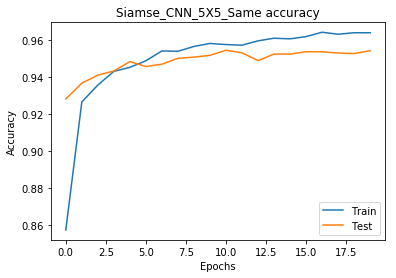

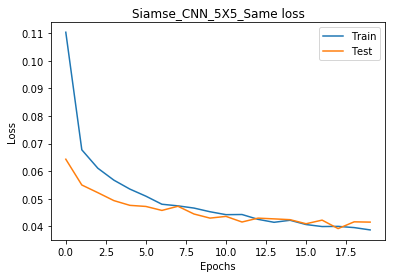

In [24]:
# plot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Siamse_CNN_5X5_Same accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Siamse_CNN_5X5_Same loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [23]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
# training accuracy
tr_acc = compute_accuracy(tr_y, y_pred)

y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
# testing accuracy
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 97.53%
* Accuracy on test set: 95.44%


In [ ]:
from sklearn.externals import joblib

siamese_cnn_val_acc = history.history['val_accuracy']
joblib.dump( siamese_cnn_val_acc, r"results\siamese_cnn_val_acc" )

filepath = r"models\siamese-cnn"     
joblib.dump(model ,filepath )

